In [1]:
import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

import tensorflow.compat.v1 as tf

#gia ta erwthmata 2-3 prepei na parw apo to endiameso epipedo
#ayto to kanw me to OUTPUT_TENSOR_NAME2 kai thn runFor23 pou to xrhsimopoiei san e3odo
class DeepLabModel(object):
  """Class to load deeplab model and run inference."""

  INPUT_TENSOR_NAME = 'ImageTensor:0'
  OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
  OUTPUT_TENSOR_NAME2 = "MobilenetV2/expanded_conv/output:0"
  INPUT_SIZE = 513
  FROZEN_GRAPH_NAME = 'frozen_inference_graph'

  def __init__(self, tarball_path):
    """Creates and loads pretrained deeplab model."""
    self.graph = tf.Graph()

    graph_def = None
    # Extract frozen graph from tar archive.
    tar_file = tarfile.open(tarball_path)
    for tar_info in tar_file.getmembers():
      if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
        file_handle = tar_file.extractfile(tar_info)
        graph_def = tf.GraphDef.FromString(file_handle.read())
        break

    tar_file.close()

    if graph_def is None:
      raise RuntimeError('Cannot find inference graph in tar archive.')

    with self.graph.as_default():
      tf.import_graph_def(graph_def, name='')

    self.sess = tf.Session(graph=self.graph)
    
  def runFor23(self, image):
    """Runs inference on a single image.

    Args:
      image: A PIL.Image object, raw input image.

    Returns:
      resized_image: RGB image resized from original input image.
      seg_map: Segmentation map of `resized_image`.
    """
    width, height = image.size
    resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
    target_size = (int(resize_ratio * width), int(resize_ratio * height))
    resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
    batch_seg_map = self.sess.run(
        self.OUTPUT_TENSOR_NAME2,
        feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
    seg_map = batch_seg_map[0]
    return seg_map

  def run(self, image):
    """Runs inference on a single image.

    Args:
      image: A PIL.Image object, raw input image.

    Returns:
      resized_image: RGB image resized from original input image.
      seg_map: Segmentation map of `resized_image`.
    """
    width, height = image.size
    resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
    target_size = (int(resize_ratio * width), int(resize_ratio * height))
    resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
    batch_seg_map = self.sess.run(
        self.OUTPUT_TENSOR_NAME,
        feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
    seg_map = batch_seg_map[0]
    return resized_image, seg_map


def create_pascal_label_colormap():
  """Creates a label colormap used in PASCAL VOC segmentation benchmark.

  Returns:
    A Colormap for visualizing segmentation results.
  """
  colormap = np.zeros((256, 3), dtype=int)
  ind = np.arange(256, dtype=int)

  for shift in reversed(range(8)):
    for channel in range(3):
      colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

  return colormap


def label_to_color_image(label):
  """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = create_pascal_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]


def vis_segmentation(image, seg_map):
  """Visualizes input image, segmentation map and overlay view."""
  plt.figure(figsize=(15, 5))
  grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

  plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  plt.subplot(grid_spec[1])
  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('segmentation map')

  plt.subplot(grid_spec[2])
  plt.imshow(image)
  plt.imshow(seg_image, alpha=0.7)
  plt.axis('off')
  plt.title('segmentation overlay')

  unique_labels = np.unique(seg_map)
  ax = plt.subplot(grid_spec[3])
  plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right()
  plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
  plt.xticks([], [])
  ax.tick_params(width=0.0)
  plt.grid('off')
  plt.show()


LABEL_NAMES = np.asarray([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

MODEL_NAME = 'mobilenetv2_coco_voctrainaug'  # @param ['mobilenetv2_coco_voctrainaug', 'mobilenetv2_coco_voctrainval', 'xception_coco_voctrainaug', 'xception_coco_voctrainval']

_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
_MODEL_URLS = {
    'mobilenetv2_coco_voctrainaug':
        'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
    'mobilenetv2_coco_voctrainval':
        'deeplabv3_mnv2_pascal_trainval_2018_01_29.tar.gz',
    'xception_coco_voctrainaug':
        'deeplabv3_pascal_train_aug_2018_01_04.tar.gz',
    'xception_coco_voctrainval':
        'deeplabv3_pascal_trainval_2018_01_04.tar.gz',
}
_TARBALL_NAME = 'deeplab_model.tar.gz'

model_dir = tempfile.mkdtemp()
tf.gfile.MakeDirs(model_dir)

download_path = os.path.join(model_dir, _TARBALL_NAME)
print('downloading model, this might take a while...')
urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME],
                   download_path)
print('download completed! loading DeepLab model...')

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

downloading model, this might take a while...
download completed! loading DeepLab model...
model loaded successfully!


running deeplab on image 3c4428be9a19b4272a04d4b8552d2f8a.jpg...


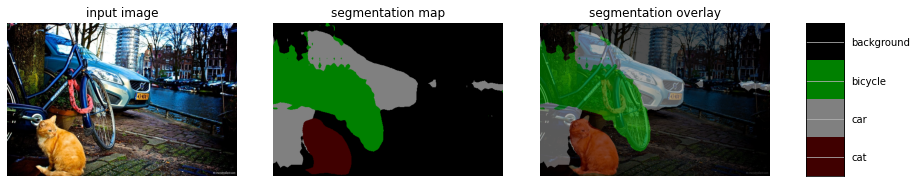

running deeplab on image 97182603-black-dining-table-in-open-space-interior-with-plants-and-bed-against-white-wall-with-green-painting.jpg...


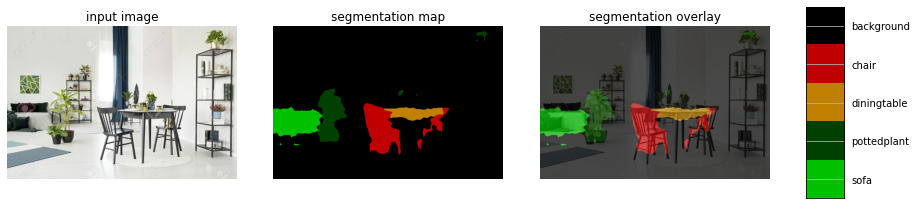

running deeplab on image 105996017-dog-next-to-dining-table-and-chairs-under-lamps-in-house-interior-with-pastel-fridge-real-photo.jpg...


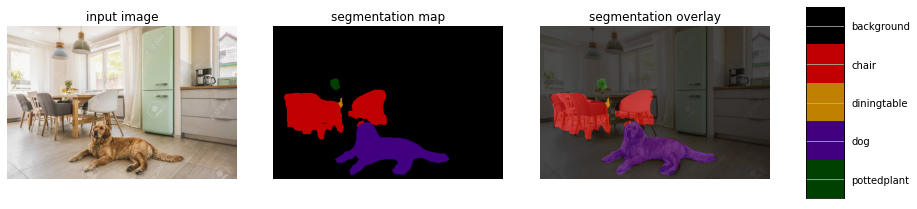

running deeplab on image maxresdefault.jpg...


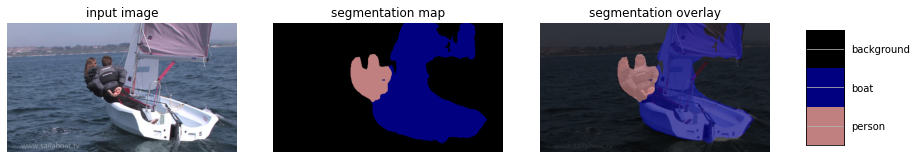

running deeplab on image unnamed.jpg...


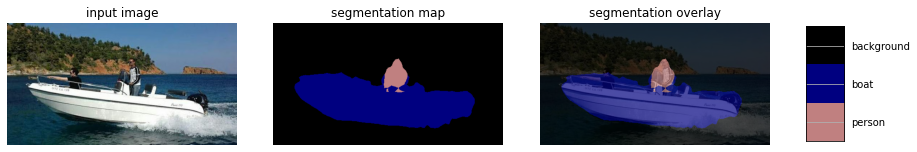

In [2]:
#diavazw thn eikona kai thn emfanizw
def run_visualization(url):
  original_im = Image.open(url)

  print('running deeplab on image %s...' % url)
  resized_im, seg_map = MODEL.run(original_im)

  vis_segmentation(resized_im, seg_map)


run_visualization('3c4428be9a19b4272a04d4b8552d2f8a.jpg')
run_visualization('97182603-black-dining-table-in-open-space-interior-with-plants-and-bed-against-white-wall-with-green-painting.jpg')
run_visualization('105996017-dog-next-to-dining-table-and-chairs-under-lamps-in-house-interior-with-pastel-fridge-real-photo.jpg')
run_visualization('maxresdefault.jpg')
run_visualization('unnamed.jpg')


running deeplab on image 3c4428be9a19b4272a04d4b8552d2f8a.jpg...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


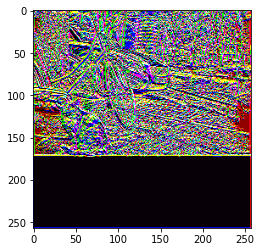

running deeplab on image 97182603-black-dining-table-in-open-space-interior-with-plants-and-bed-against-white-wall-with-green-painting.jpg...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


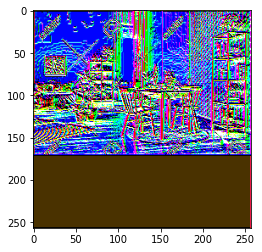

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


running deeplab on image 105996017-dog-next-to-dining-table-and-chairs-under-lamps-in-house-interior-with-pastel-fridge-real-photo.jpg...


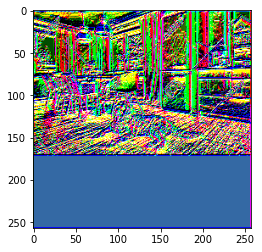

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


running deeplab on image maxresdefault.jpg...


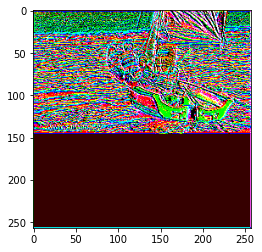

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


running deeplab on image unnamed.jpg...


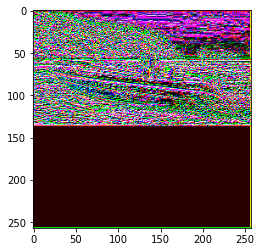

In [3]:
from sklearn.decomposition import PCA
#emfanizei to apotelesma tou PCA
#gia na efmanistei pairnw thn exodo apo to endiameso epipedo
#kai thn kanw PCA me n_components = 3
#afou thn metasxhmatisw thn emfanizw
def run_visualization_pca(url):
  original_im = Image.open(url)

  print('running deeplab on image %s...' % url)
  new_im = MODEL.runFor23(original_im)
  forPCA = np.reshape(new_im, (-1, new_im.shape[2]))
  objectPCA = PCA(n_components = 3).fit(forPCA)
  new_im2 = objectPCA.transform(forPCA)
  plt.imshow(new_im2.reshape((new_im.shape[0], new_im.shape[1], 3)))
  plt.show()
    
run_visualization_pca('3c4428be9a19b4272a04d4b8552d2f8a.jpg')
run_visualization_pca('97182603-black-dining-table-in-open-space-interior-with-plants-and-bed-against-white-wall-with-green-painting.jpg')
run_visualization_pca('105996017-dog-next-to-dining-table-and-chairs-under-lamps-in-house-interior-with-pastel-fridge-real-photo.jpg')
run_visualization_pca('maxresdefault.jpg')
run_visualization_pca('unnamed.jpg')

running deeplab on image 3c4428be9a19b4272a04d4b8552d2f8a.jpg...


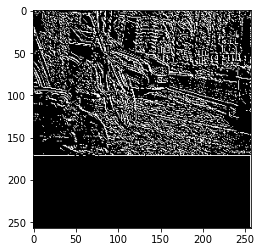

running deeplab on image 97182603-black-dining-table-in-open-space-interior-with-plants-and-bed-against-white-wall-with-green-painting.jpg...


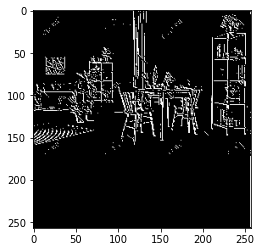

running deeplab on image 105996017-dog-next-to-dining-table-and-chairs-under-lamps-in-house-interior-with-pastel-fridge-real-photo.jpg...


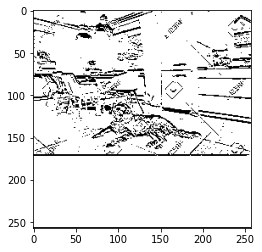

running deeplab on image maxresdefault.jpg...


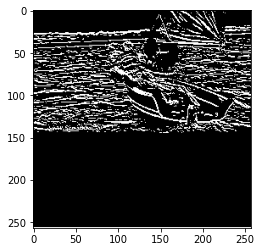

running deeplab on image unnamed.jpg...


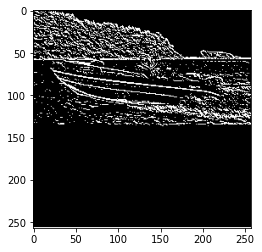

In [4]:
from sklearn.cluster import KMeans
#o kmeans kaleitai gia 2 omades sto apotelesma tou PCA gia 8 component
def run_visualization_kmeans(url):
  original_im = Image.open(url)

  print('running deeplab on image %s...' % url)
  new_im = MODEL.runFor23(original_im)
  forPCA = np.reshape(new_im, (-1, new_im.shape[2]))
  objectPCA = PCA(n_components = 8)
  objectPCA.fit(forPCA)
  new_im2 = objectPCA.transform(forPCA)
  objectKmeans = KMeans(n_clusters = 2)
  objectKmeans.fit_predict(new_im2)
  labelsOfIm = objectKmeans.labels_
  plt.imshow(labelsOfIm.reshape((new_im.shape[0], new_im.shape[1])), cmap = 'gray')
  plt.show()
    
run_visualization_kmeans('3c4428be9a19b4272a04d4b8552d2f8a.jpg')
run_visualization_kmeans('97182603-black-dining-table-in-open-space-interior-with-plants-and-bed-against-white-wall-with-green-painting.jpg')
run_visualization_kmeans('105996017-dog-next-to-dining-table-and-chairs-under-lamps-in-house-interior-with-pastel-fridge-real-photo.jpg')
run_visualization_kmeans('maxresdefault.jpg')
run_visualization_kmeans('unnamed.jpg')